In [50]:
import os
import shutil
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import joblib


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef
)

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
data_path = "data"
models_path = "."
os.makedirs(models_path,exist_ok=True)
# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
if os.path.exists(data_path):
  shutil.rmtree(data_path)

print("Path to dataset files:", path)
shutil.copytree(path, data_path)
print(os.listdir(data_path))

file_path = None
for item in os.listdir(data_path):
  file_path = os.path.join(data_path,item)


data = pd.read_csv(file_path)
display(data.head())

Path to dataset files: C:\Users\abhis\.cache\kagglehub\datasets\fedesoriano\heart-failure-prediction\versions\1
['heart.csv']


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [52]:
data.shape

(918, 12)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [54]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [55]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

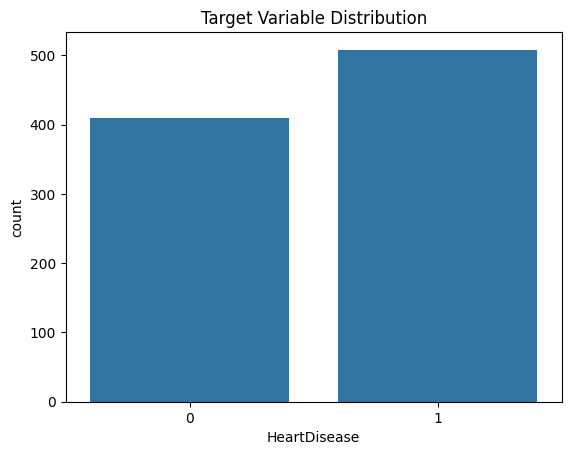

In [56]:
sns.countplot(x='HeartDisease', data=data)
plt.title("Target Variable Distribution")
plt.show()

In [57]:
target_col = 'HeartDisease'
cat_cols = data.select_dtypes(include=["object"]).columns
for col in cat_cols:
    data[col] = data[col].astype("category").cat.codes
class_counts = data[target_col].value_counts()
for cls, count in class_counts.items():
    print(f"   Class {cls}: {count:,} ({count/len(data)*100:.2f}%)")



   Class 1: 508 (55.34%)
   Class 0: 410 (44.66%)


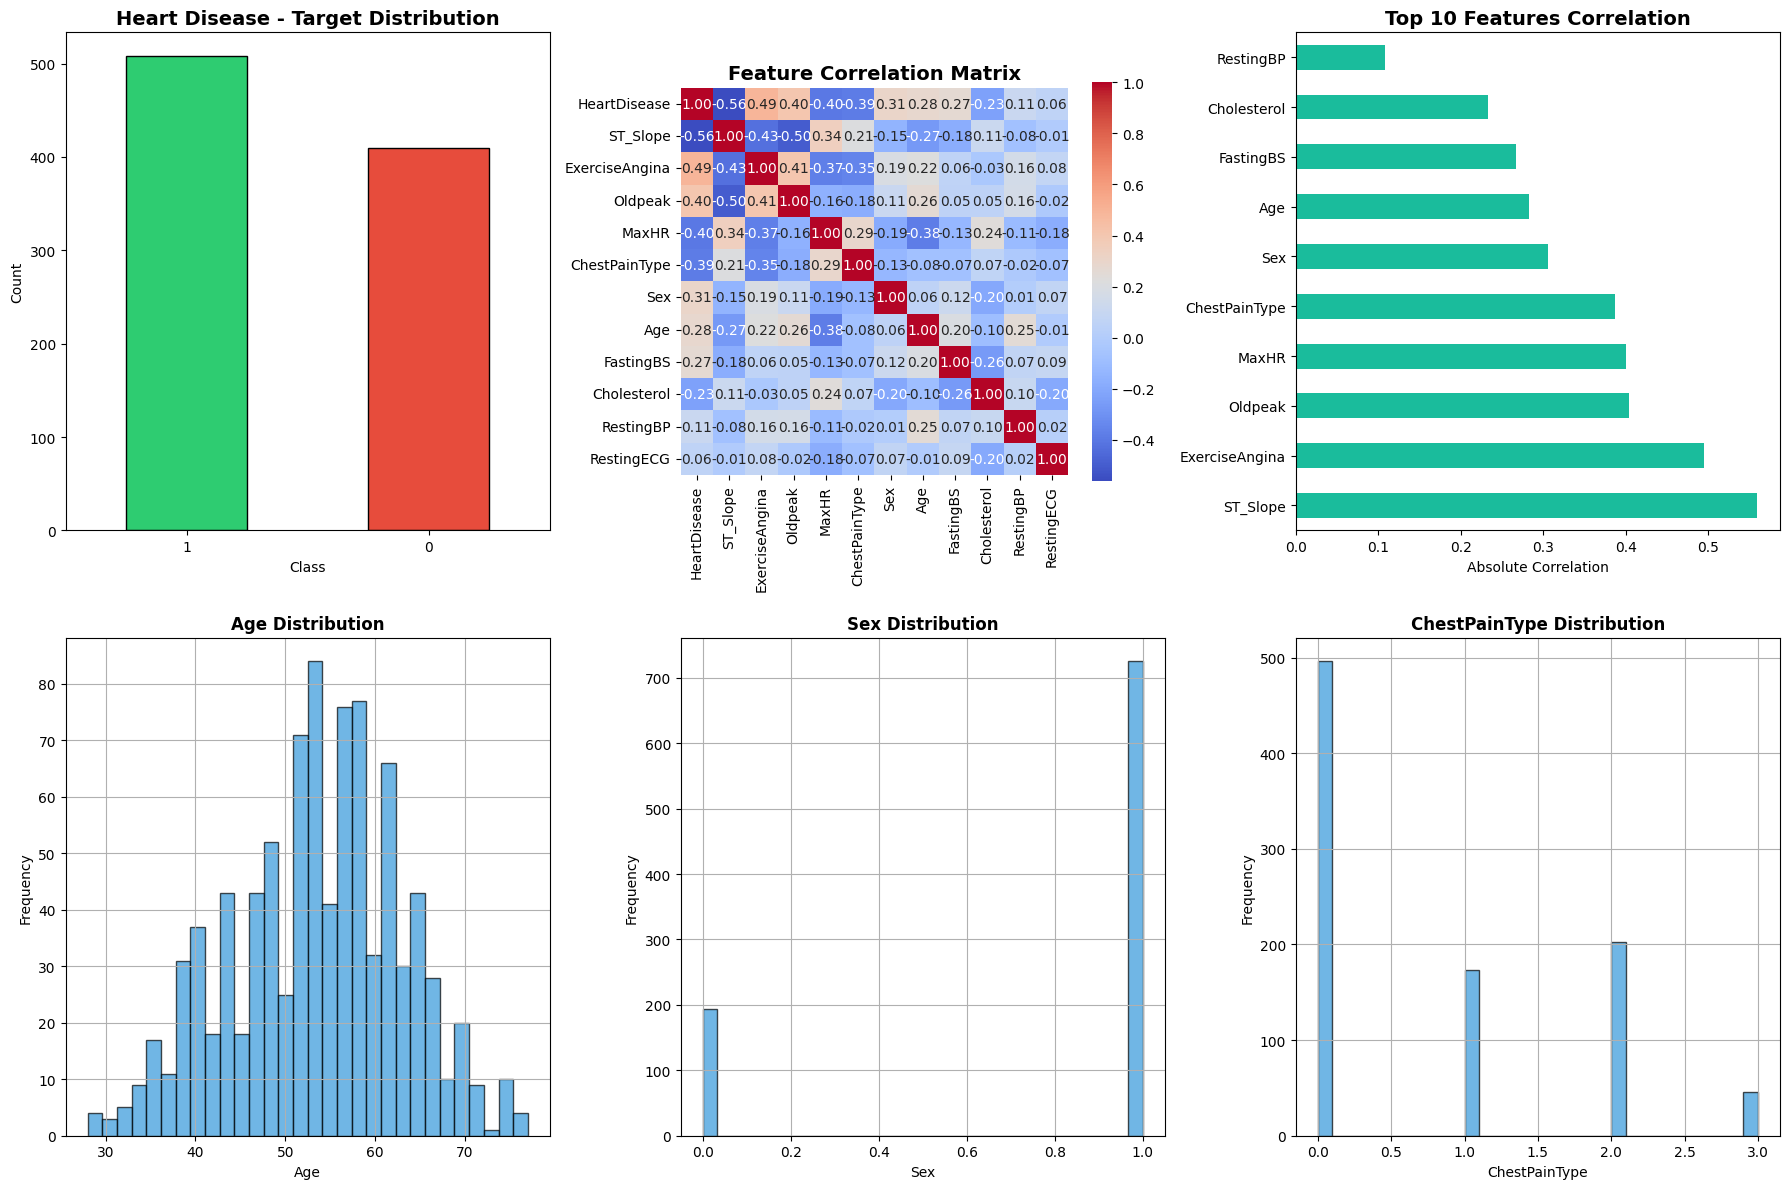

In [58]:
# Visualizations
fig = plt.figure(figsize=(18, 12))

# Target distribution
plt.subplot(2, 3, 1)
class_counts.plot(kind='bar', color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.title(f'{"Heart Disease"} - Target Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Correlation heatmap (top 15 features)
plt.subplot(2, 3, 2)
corr_matrix = data.corr()
top_features = corr_matrix[target_col].abs().sort_values(ascending=False).head(16).index
sns.heatmap(data[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm',
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Top correlations with target
plt.subplot(2, 3, 3)
correlations = corr_matrix[target_col].abs().sort_values(ascending=False)[1:11]
correlations.plot(kind='barh', color='#1abc9c')
plt.title('Top 10 Features Correlation', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation')

# Feature distributions (numeric only)
numeric_cols = data.select_dtypes(include=[np.number]).columns
sample_cols = [col for col in numeric_cols if col != target_col][:3]

for idx, col in enumerate(sample_cols, start=4):
    plt.subplot(2, 3, idx)
    data[col].hist(bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    plt.title(f'{col} Distribution', fontsize=12, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [59]:
def engineer_heart_failure_features(df):
  """Feature engineering for Heart Failure dataset"""
  print("\n Feature Engineering - Heart Failure Dataset...")
  df_fe = df.copy()

  # Add interaction features if applicable
  numeric_cols = df_fe.select_dtypes(include=[np.number]).columns
  print(f" Dataset ready with {len(numeric_cols)} features")

  return df_fe

df_heart_failure_fe = engineer_heart_failure_features(data)


 Feature Engineering - Heart Failure Dataset...
 Dataset ready with 12 features


In [60]:
scaler = StandardScaler()
def preprocess( df, target_col, strategy = 'smote', test_size=0.2):
        """Complete preprocessing pipeline"""

        print(f"\n{'=' * 80}")
        print(f"🔧 DATA PREPROCESSING")
        print(f"{'=' * 80}")

        # Separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]

        print(f"\n1️⃣ Data Split:")
        print(f"   Features: {X.shape}")
        print(f"   Target: {y.shape}")

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        print(f"\n2️⃣ Train-Test Split:")
        print(f"   Training: {X_train.shape[0]:,} samples")
        print(f"   Testing: {X_test.shape[0]:,} samples")

        # Feature scaling
        print(f"\n3️⃣ Feature Scaling...")
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print("   ✅ StandardScaler applied")

        # Handle class imbalance
        print(f"\n4️⃣ Handling Class Imbalance (Strategy: {strategy})...")
        print(f"   Before:")
        print(f"      Class 0: {(y_train == 0).sum():,}")
        print(f"      Class 1: {(y_train == 1).sum():,}")

        if strategy == 'smote':
          smote = SMOTE(random_state=42, k_neighbors=5)
          X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        else :
          X_train_balanced = X_train_scaled
          y_train_balanced = y_train



        print(f"   After:")
        print(f"      Class 0: {(y_train_balanced == 0).sum():,}")
        print(f"      Class 1: {(y_train_balanced == 1).sum():,}")
        print("   ✅ Balancing complete")

        return {
            'X_train': X_train_balanced,
            'X_test': X_test_scaled,
            'X_test_raw': X_test,
            'y_train': y_train_balanced,
            'y_test': y_test,
            'feature_names': X.columns.tolist()
        }

print("\n" + "=" * 80)
print("PREPROCESSING HEART FAILURE DATASET")
print("=" * 80)
data_hf = preprocess(df_heart_failure_fe, target_col, strategy='None')


PREPROCESSING HEART FAILURE DATASET

🔧 DATA PREPROCESSING

1️⃣ Data Split:
   Features: (918, 11)
   Target: (918,)

2️⃣ Train-Test Split:
   Training: 734 samples
   Testing: 184 samples

3️⃣ Feature Scaling...
   ✅ StandardScaler applied

4️⃣ Handling Class Imbalance (Strategy: None)...
   Before:
      Class 0: 328
      Class 1: 406
   After:
      Class 0: 328
      Class 1: 406
   ✅ Balancing complete


In [61]:
joblib.dump(scaler, os.path.join(models_path,"scaler.pkl"))


['.\\scaler.pkl']

In [62]:
# Save raw (unscaled) test split as CSV for Streamlit app demo
test_df = data_hf['X_test_raw'].copy()
test_df[target_col] = data_hf['y_test'].values
test_csv_path = os.path.join(data_path, "test_data.csv")
test_df.to_csv(test_csv_path, index=False)
print(f"Test data saved to: {test_csv_path}")
print(f"Shape: {test_df.shape}")

Test data saved to: data\test_data.csv
Shape: (184, 12)


In [63]:
class ModelTrainer:
    """Unified model training and evaluation"""

    def __init__(self):
        self.models = self._initialize_models()
        self.results = []
        self.trained_models = {}

    def _initialize_models(self):
        """Initialize all models with optimized hyperparameters"""
        return {
            '1.Logistic Regression': LogisticRegression(
                C=1.0,
                max_iter=1000,
                penalty='l2',
                random_state=42,
                n_jobs=-1
            ),

            '2.Decision Tree': DecisionTreeClassifier(
                max_depth=10,
                random_state=42
            ),

            '3.KNN': KNeighborsClassifier(
                n_neighbors=5
            ),

            '4.Gaussian Naive Bayes': GaussianNB(),


            '5.Random Forest': RandomForestClassifier(
                n_estimators=300,
                max_depth=20,
                min_samples_split=10,
                min_samples_leaf=4,
                max_features='sqrt',
                random_state=42,
                n_jobs=-1
            ),

            '6.XGBoost': XGBClassifier(
                n_estimators=300,
                max_depth=7,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                eval_metric='logloss'
            )
        }

    def train_all_models(self, X_train, y_train, X_test, y_test, dataset_name="Dataset"):
        """Train and evaluate all models"""

        print(f"\n{'=' * 80}")
        print(f" MODEL TRAINING - {dataset_name}")
        print(f"{'=' * 80}")
        print(f"\n Total Models: {len(self.models)}")
        print(f"  Training in progress...\n")

        self.results = []
        self.trained_models = {}

        for i, (name, model) in enumerate(self.models.items(), 1):
            print(f"\n{'=' * 70}")
            print(f"[{i}/{len(self.models)}] Training: {name}")
            print(f"{'=' * 70}")

            try:
                # Train
                model.fit(X_train, y_train)

                # Predict
                y_pred = model.predict(X_test)

                # Probability predictions
                if hasattr(model, 'predict_proba'):
                    y_pred_proba = model.predict_proba(X_test)[:, 1]
                else:
                    y_pred_proba = y_pred

                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                roc_auc = roc_auc_score(y_test, y_pred_proba) if hasattr(model, 'predict_proba') else 0
                mcc = matthews_corrcoef(y_test, y_pred)


                # Print results
                print(f"\n Results:")
                print(f"   Accuracy:     {accuracy*100:>6.2f}%")
                print(f"   Precision:    {precision*100:>6.2f}%")
                print(f"   Recall:       {recall*100:>6.2f}%")
                print(f"   F1-Score:     {f1*100:>6.2f}%")
                print(f"   ROC-AUC:      {roc_auc:>6.4f}")
                print(f"   MCC      : {mcc:.4f}")
                # print(f"   CV Score:     {cv_mean*100:>6.2f}% (±{cv_std*100:.2f}%)")

                # Store results
                self.results.append({
                    'Model': name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-Score': f1,
                    'ROC-AUC': roc_auc,
                    'MCC': mcc,
                })

                self.trained_models[name] = model
                print(f"    Training complete!")

            except Exception as e:
                print(f"    Error: {str(e)}")

        print(f"\n{'=' * 80}")
        print(" ALL MODELS TRAINED SUCCESSFULLY!")
        print(f"{'=' * 80}")

        return pd.DataFrame(self.results)

    def get_best_model(self, results_df):
        """Get the best performing model"""
        best_idx = results_df['F1-Score'].idxmax()
        best_model_name = results_df.loc[best_idx, 'Model']
        return best_model_name, self.trained_models[best_model_name], results_df.loc[best_idx]

    def save_models(self, save_dir="saved_models"):
        """Save all trained models to disk"""

        if not self.trained_models:
            print("No trained models found. Train models first.")
            return

        os.makedirs(save_dir, exist_ok=True)

        for name, model in self.trained_models.items():
            #filename = name.replace(" ", "_").replace(".", "") + ".pkl"
            filename = name.split(".")[-1].replace(" ", "_")+".pkl"
            filepath = os.path.join(save_dir, filename)

            joblib.dump(model, filepath)
            print(f" Saved: {filepath}")

        print("\n All models saved successfully!")



trainer_hf = ModelTrainer()
results_hf = trainer_hf.train_all_models(
    data_hf['X_train'], data_hf['y_train'],
    data_hf['X_test'], data_hf['y_test'],
    "Heart Failure Dataset"
)

trainer_hf.save_models(models_path)


 MODEL TRAINING - Heart Failure Dataset

 Total Models: 6
  Training in progress...


[1/6] Training: 1.Logistic Regression

 Results:
   Accuracy:      86.96%
   Precision:     84.82%
   Recall:        93.14%
   F1-Score:      88.79%
   ROC-AUC:      0.8971
   MCC      : 0.7374
    Training complete!

[2/6] Training: 2.Decision Tree

 Results:
   Accuracy:      79.35%
   Precision:     81.37%
   Recall:        81.37%
   F1-Score:      81.37%
   ROC-AUC:      0.7958
   MCC      : 0.5820
    Training complete!

[3/6] Training: 3.KNN

 Results:
   Accuracy:      89.13%
   Precision:     89.42%
   Recall:        91.18%
   F1-Score:      90.29%
   ROC-AUC:      0.9192
   MCC      : 0.7797
    Training complete!

[4/6] Training: 4.Gaussian Naive Bayes

 Results:
   Accuracy:      89.13%
   Precision:     89.42%
   Recall:        91.18%
   F1-Score:      90.29%
   ROC-AUC:      0.9280
   MCC      : 0.7797
    Training complete!

[5/6] Training: 5.Random Forest

 Results:
   Accuracy:      8


MODEL PERFORMANCE COMPARISON (SORTED BY RECALL)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,MCC
0,1.Logistic Regression,0.869565,0.848214,0.931373,0.887850,0.897059,0.737401
4,5.Random Forest,0.880435,0.870370,0.921569,0.895238,0.927308,0.757938
3,4.Gaussian Naive Bayes,0.891304,0.894231,0.911765,0.902913,0.928025,0.779672
2,3.KNN,0.891304,0.894231,0.911765,0.902913,0.919237,0.779672
5,6.XGBoost,0.869565,0.890000,0.872549,0.881188,0.920851,0.736819
1,2.Decision Tree,0.793478,0.813725,0.813725,0.813725,0.795791,0.582018


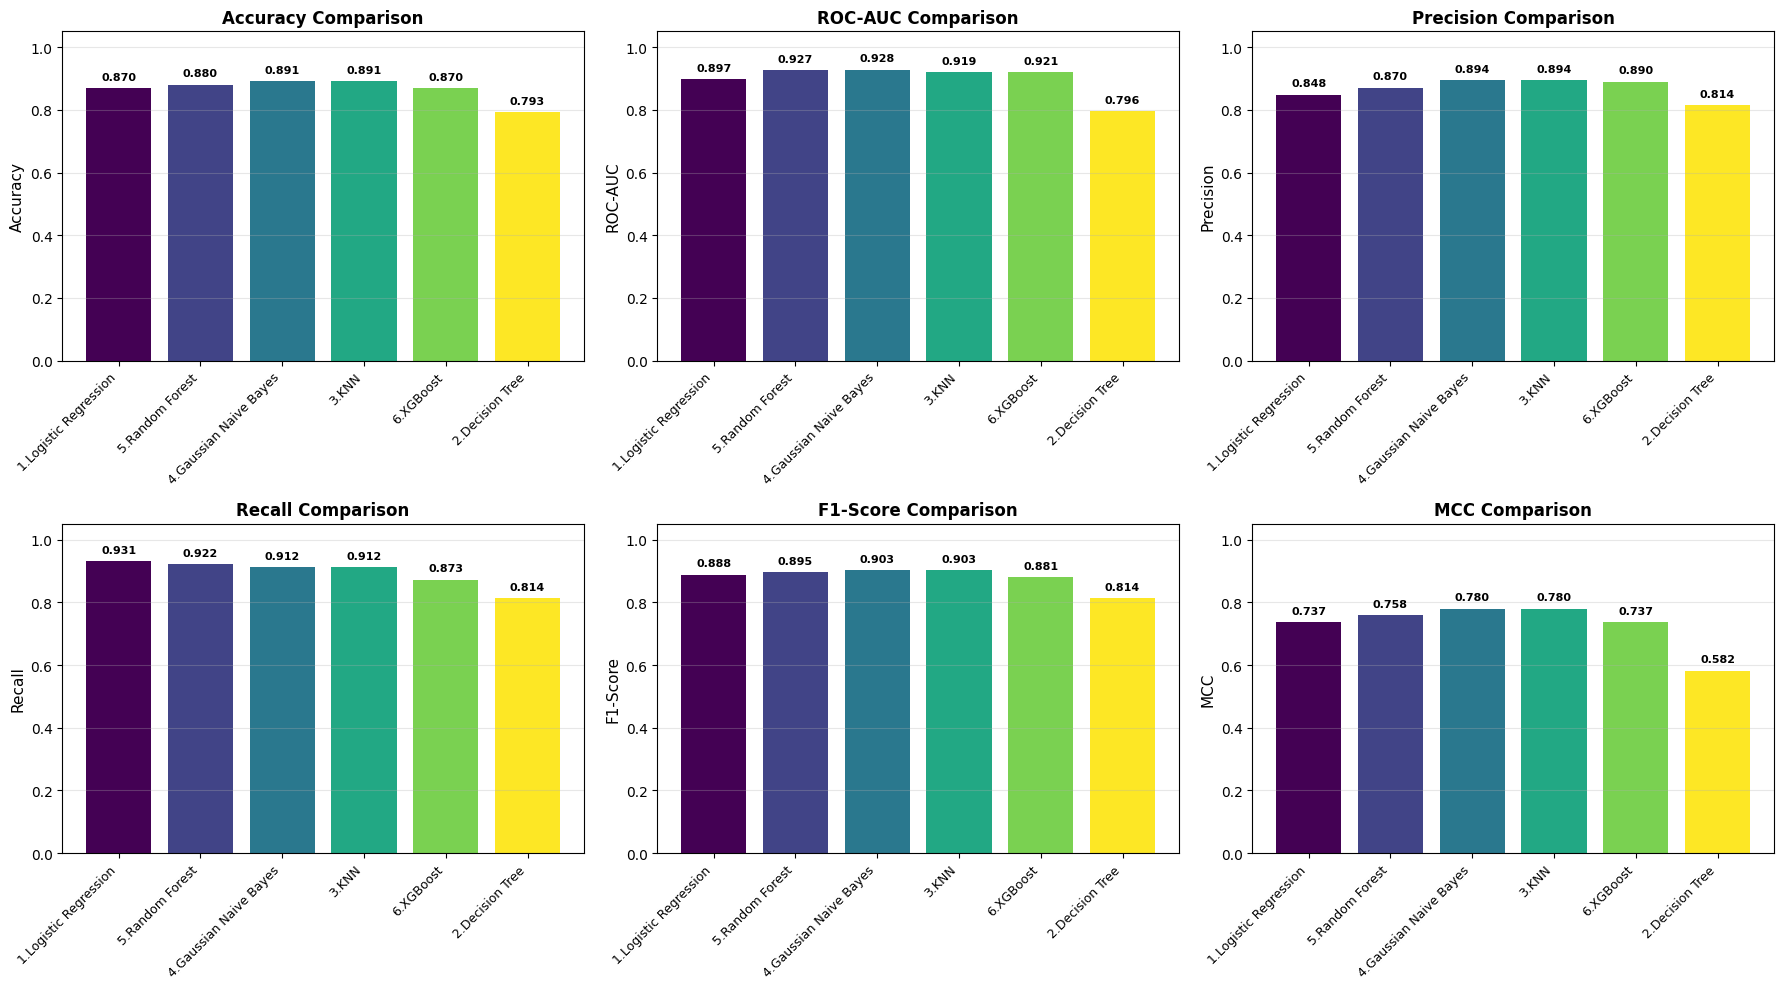

✓ Visualization saved as 'model_comparison.png'


In [64]:
print("\n" + "="*90)
print("MODEL PERFORMANCE COMPARISON (SORTED BY RECALL)")
print("="*90)

comparison_df = results_hf.sort_values(by="Recall", ascending=False)

display(comparison_df)

formatted_df = comparison_df.copy()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics_to_plot = ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score', 'MCC']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    values = comparison_df[metric].values
    models = comparison_df['Model'].values

    bars = ax.bar(range(len(models)), values, color=plt.cm.viridis(np.linspace(0, 1, len(models))))
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'model_comparison.png'")

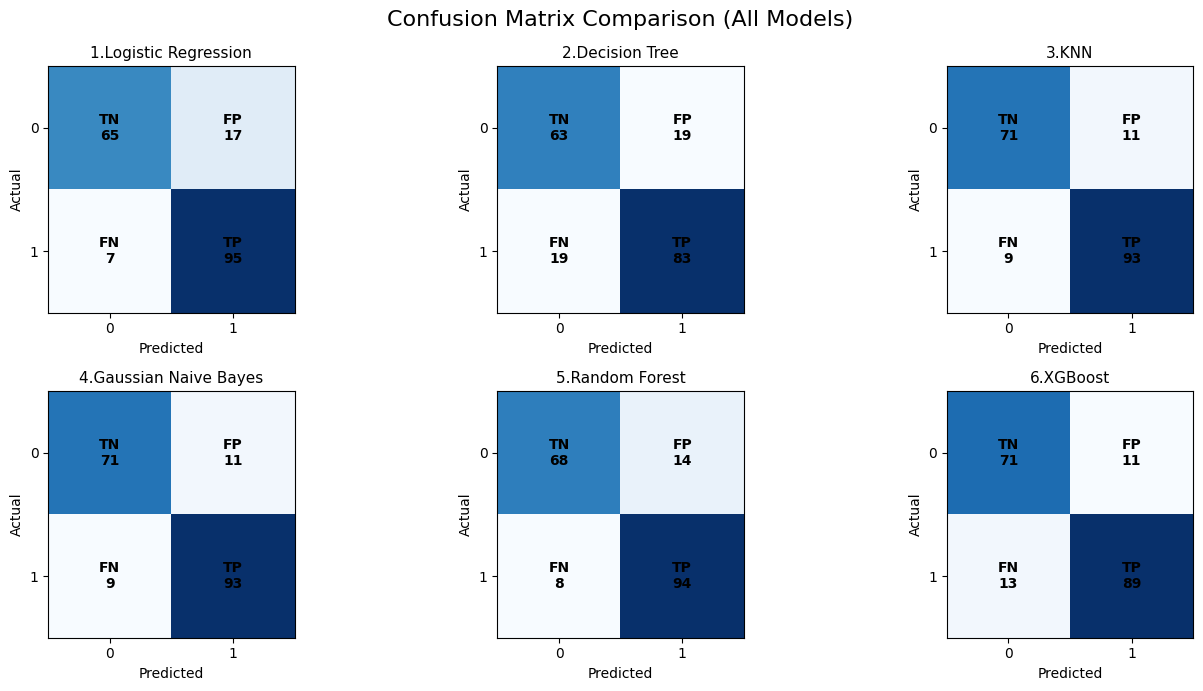

In [65]:

models = trainer_hf.trained_models
n_models = len(models)

cols = 3
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 7))
axes = axes.flatten()

for i, (model_name, model) in enumerate(models.items()):

    y_pred = model.predict(data_hf['X_test'])
    cm = confusion_matrix(data_hf['y_test'], y_pred)

    ax = axes[i]
    ax.imshow(cm, cmap="Blues")  # clean grayscale

    # Add text labels inside cells
    labels = np.array([
        [f"TN\n{cm[0,0]}", f"FP\n{cm[0,1]}"],
        [f"FN\n{cm[1,0]}", f"TP\n{cm[1,1]}"]
    ])

    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, labels[j, k],
                ha='center', va='center',
                fontsize=10, fontweight='bold')

    ax.set_title(model_name, fontsize=11)
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Remove extra empty plots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrix Comparison (All Models)", fontsize=16)
plt.tight_layout()
plt.show()
